# Trabajo Práctico 2: Enunciado 

El segundo TP es una competencia de Machine Learning en donde cada grupo debe intentar determinar, para cada tweet brindado, si el mismo esta basado en un hecho real o no.

La competencia se desarrolla en la plataforma de Kaggle  https://www.kaggle.com/c/nlp-getting-started.  

El dataset consta de una serie de tweets, para los cuales se informa:

<br/>

* id - identificador unico para cada  tweet
* text - el texto del tweet
* location - ubicación desde donde fue enviado (podría no estar)
* keyword - un keyword para el tweet  (podría faltar)
* target - en train.csv, indica si se trata de un desastre real  (1) o no (0)
 
<br/><br/>


Los submits con el resultado deben tener el formato:

Id: Un id numérico para identificar el tweet
target: 1 / 0 según se crea que el tweet se trata sobre un desastre real, o no.

Los grupos deberán probar distintos algoritmos de Machine Learning para intentar predecir si el tweet está basado en hechos reales o no. A medida que los grupos realicen pruebas deben realizar el correspondiente submit en Kaggle para evaluar el resultado de los mismos.

Al finalizar la competencia el grupo que mejor resultado tenga obtendrá 10 puntos para cada uno de sus integrantes que podrán ser usados en el examen por promoción o segundo recuperatorio.

Requisitos para la entrega del TP2:

- El TP debe programarse en Python o R.
- Debe entregarse un pdf con el informe de algoritmos probados, algoritmo final utilizado, transformaciones realizadas a los datos, feature engineering, etc. 
- El informe debe incluir también un link a github con el informe presentado en pdf, y todo el código.
- El grupo debe presentar el TP en una computadora en la fecha indicada por la cátedra, el TP debe correr en un lapso de tiempo razonable (inferior a 1 hora) y generar un submission válido que iguale el mejor resultado obtenido por el grupo en Kaggle. (mas detalles a definir)

El TP2 se va a evaluar en función del siguiente criterio:

- Cantidad de trabajo (esfuerzo) del grupo: ¿Probaron muchos algoritmos? ¿Hicieron un buen trabajo de pre-procesamiento de los datos y feature engineering?
- Resultado obtenido en Kaggle (obviamente cuanto mejor resultado mejor nota)
- Presentación final del informe, calidad de la redacción, uso de información obtenida en el TP1, conclusiones presentadas.
- Performance de la solución final.


# 1. Preprocesado
#### Introducción 
Se levantan los datos como en el TP1. Sin EDA, solo el preprocesado del texto.

### 1.1 Instalación de librerias 

In [2]:
!pip3 install nltk
!pip3 install stopwords
!pip3 install gensim

!pip3 install sklearn
!pip3 install xgboost==0.7.post4

!pip3 install tensorflow
!pip3 install tensorflow_hub
!pip3 install "tqdm>=4.46.0"


### 1.2 Importación de librerías

In [36]:
import pandas as pd
import numpy as np

import warnings
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn import model_selection

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron
from sklearn.metrics import f1_score,roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from time import process_time

import tensorflow_hub as hub 
import tensorflow as tf 

from tqdm.notebook import tqdm 
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alejandro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alejandro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alejandro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alejandro/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alejandro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1.3 Obtención de datos
Lectura de datos de entrenamiento y test.

In [5]:
tweets_train = pd.read_csv('../data/train.csv', encoding='utf-8')
tweets_test = pd.read_csv('../data/test.csv', encoding='utf-8')

### 1.4 Limpieza de datos.
#### Introducción
Antes de empezar, hay que normalizar el texto ya que luego de la tokenización serán convertidos en vectores dentro de una matriz, las técnicas a utilizar:
* **Uppercase/lowercase**: Paso todo a lower/upper case, ya que una misma palabra tiene una representación distinta si se hay un cambio de mayúscula minúscula.
* **Limpieza de texto**: Signos de puntuación, valores numéricos, links, carácteres especiales, etc.
* **Tokenizacion**: Es el proceso de convertir el texto en una lista de tokens,
* **Stopwords**: Elimino palabras comunes que no aportan información
* **Stemming**: Elimino los sufijos de palabras que puedan tener el mismo significado (o función dentro del texto)
* **Lemmatization**: Unifico palabras que signifiquen lo mismo en base a su definición del diccionario

Inicializo dataset para probar las funciones

In [6]:
#Copia de datasets para trabajar el pre-procesado de texto
train_df1 = tweets_train.copy()
test_df1  = tweets_test.copy()

#### 1.4.1 Uppercase + Limpieza de texto

In [7]:
#Funcion para eliminar emojis, viene del tp1
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

def remove_emojis_non_ascii(text):    
    #replace consecutive non-ASCII characters with a space
    result = re.sub(r'[^\x00-\x7F]+',' ', text)
    #remove emojis from tweet
    result = emoji_pattern.sub(r'', result)    
    return result


#Funcion para limpieza del texto (todo a LOWERCASE)
def text_clean(text):
    text = text.lower()
    text = remove_emojis_non_ascii(text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [8]:
#Aplico la funcion a la copia de los Dataset de entrenamiento y test
train_df1['text'] = train_df1['text'].apply(lambda x: text_clean(x))
test_df1['text'] = test_df1['text'].apply(lambda x: text_clean(x))

#### 1.4.2 Tokenización
_Probar los distintos que ofrece la librería nltk_

In [9]:
#Para tokenizar utilizo el RegEx tokenizer de nltk
#tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

#Para tokenizar utilizo WhitespaceTokenizer
#tokenizer = nltk.tokenize.WhitespaceTokenizer()

#Para tokenizar utilizo WordPunctTokenizer
#tokenizer = nltk.tokenize.WordPunctTokenizer()

#Para tokenizar utilizo TreebankWordTokenizer
self_tokenizer = nltk.tokenize.TreebankWordTokenizer()


In [10]:
train_df1['text'] = train_df1['text'].apply(lambda x: self_tokenizer.tokenize(x))
test_df1['text'] = test_df1['text'].apply(lambda x: self_tokenizer.tokenize(x))

#### 1.4.3 Stopwords

In [11]:
#Funcion para eliminar Stopwords
def text_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [12]:
train_df1['text'] = train_df1['text'].apply(lambda x : text_stopwords(x))
test_df1['text'] = test_df1['text'].apply(lambda x : text_stopwords(x))

#### 1.4.4 Stemming + Lemmatizing
Probar si aportan algo

In [13]:
# Funcion para Stemming y Lemmatizing
def text_stemming(text):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    stemmer = nltk.stem.PorterStemmer()
    text_stemmed = " ".join(stemmer.stem(token) for token in tokens)
    return text_stemmed

def text_lemmatizing(text):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    lemmatizer=nltk.stem.WordNetLemmatizer()
    text_lemmatized = " ".join(lemmatizer.lemmatize(token) for token in tokens)
    return text_lemmatized

In [14]:
#Combino el texto para luego de haberlo procesado
def text_combine(text):
    comb_text = ' '.join(text)
    return comb_text

In [15]:
train_df1['text'] = train_df1['text'].apply(lambda x : text_combine(x))
test_df1['text'] = test_df1['text'].apply(lambda x : text_combine(x))

In [16]:
test_df1.head() ##Datos Antes del lemmatizing

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


In [17]:
test_df1['text'] = test_df1['text'].apply(lambda x : text_lemmatizing(x))

In [18]:
test_df1.head() ##Datos luego del lemmatizing

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill china taiwan


#### 1.4.5 Pre-procesado de texto
Devuelve texto, agregar una para devolver tambien solo TOKENS, ya que es lo que se va a utilizar para entrenar al modelo

In [19]:
def pre_process_text(text): 
    cleaned_txt = text_clean(text)
    lemma_text = text_lemmatizing(cleaned_txt)
    tokenized_text = self_tokenizer.tokenize(lemma_text)    
    remove_stopwords = text_stopwords(tokenized_text)
    combined_text = text_combine(remove_stopwords)
    return combined_text

In [56]:
test_df1['text'] = test_df1['text'].apply(lambda x : pre_process_text(x))
test_df1.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill china taiwan


#### 1.4.6 Eliminacion de duplicados
Eliminamos las filas duplicadas en el set de entrenamiento que tengan un target diferente para evitar inconsistencias.

In [22]:
duplicated_rows_train = train_df2[train_df2.duplicated(['text'],keep=False)]
# de las duplicadas reviso cuales tienen target diferente
duplicated_groups = duplicated_rows_train.groupby('text', as_index=False).agg({'target':['sum',"count"]})
same_text_diff_target = duplicated_groups[(duplicated_groups['target']['sum'] != 0) & (duplicated_groups['target']['sum'] != duplicated_groups['target']['count'])]['text']
same_text_train_ids = duplicated_rows_train[duplicated_rows_train['text'].isin(same_text_diff_target)]['id']

# sacamos del train set los ids duplicados
train_df2 = train_df2.drop(train_df2[train_df2.id.isin(same_text_train_ids)].index)
# y del dataset original para evitar errores si se usa el target de ese set
tweets_train = tweets_train.drop(tweets_train[tweets_train.id.isin(same_text_train_ids)].index)
# Se eliminan unas 318 filas
tweets_train.shape 

(7295, 5)

### 1.5 Analisis de sentimientos

In [77]:
# agrego feature de sentimiento
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
train_df2['sentiment_score'] = train_df2.text.apply(lambda x: sid.polarity_scores(x)['compound'])
test_df2['sentiment_score'] = test_df2.text.apply(lambda x: sid.polarity_scores(x)['compound'])

# 2. Vectorización del texto
Para entrenar el modelo necesitamos convertir el texto a una matriz de vectores para que pueda interpretarlo, 
para lograrlo existen distintas técnicas.

* Word2Vec
* Universal Sentence Encoder
* Bag of Words
* TF-IDF
* N-Gramas
* Feature Hashing

Cada una de estas alternativas esta directamente relacionada con la transformación del texto (Tokenizacion, limpieza, lemming, stemming)

## 2.0 Preparacion de datasets
Preparo datasets de train y test aplicando el preprocesado.

In [57]:
train_df2=tweets_train.copy()
train_df2['text'] = train_df2['text'].apply(lambda x : pre_process_text(x))
train_df2['keyword'] = train_df2['keyword'].apply(lambda x : pre_process_text(str(x)))

test_df2=tweets_test.copy()
test_df2['text'] = test_df2['text'].apply(lambda x : pre_process_text(x))
test_df2['keyword'] = test_df2['keyword'].apply(lambda x : pre_process_text(str(x)))

Función para graficar (PCA) las distintas vectorizaciones

In [46]:
##Funcion interna
def plot_LSA(test_data, test_labels):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']        
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        orange_patch = mpatches.Patch(color='orange', label='Falso')
        blue_patch = mpatches.Patch(color='blue', label='Verdadero')
        plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})


list_text = train_df2["text"].tolist()
list_keyword = train_df2["keyword"].tolist()
list_labels = train_df2["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_text, list_labels, test_size=0.2, 
                                                                            random_state=32)            

##ultima funcion
##train_x es el array de la columna text, vectorizado
def Graph_vectorization(train_x,train_y,model_name):
    fig = plt.figure(figsize=(16, 16))          
    plot_LSA(train_x, train_y)
    #fig.suptitle(model_name)    
    plt.figtext(.5,.9,model_name, fontsize=30, ha='center')
    plt.show()


## 2.1 Word2Vec Embbeding


In [24]:
import gensim
import gensim.downloader as api
#glove-twitter-100 1193514 387 MB  Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased)
#glove-twitter-200 1193514 758 MB  Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased)
#glove-twitter-25  1193514 104 MB  Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased)
#glove-twitter-50  1193514 199 MB  Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased)
model = api.load("glove-twitter-200")  # download the model and return as object ready for use

#word2vec = gensim.models.KeyedVectors.load_word2vec_format(path_for_word2vec, binary = True)

In [25]:
# http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec, dimentions):
        self.word2vec = word2vec
        # dimension del vector
        self.dim = dimentions

    def fit(self, X, y):
        return self

    def transform(self, X):
        # tranformación: se busca la palabra en el modelo de w2vec, si no existe se llena con ceros el vector
        # se calcula el promedio para el vector final
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [26]:
from collections import defaultdict

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec, dimentions):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = dimentions

    def fit(self, X):
        # TODO ver si estos parametros estan OK
        tfidf = TfidfVectorizer(analyzer=lambda x: x,min_df=2, max_df=0.5, ngram_range=(2, 3))
        tfidf.fit(X)
        # Se calcula el "peso" de cada palabra: 
        # usando el mayor valor de tf-idf 
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w] for w in words if w in self.word2vec]
                        or [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [27]:
# armamos el diccionario de w2vec
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [28]:
meanEmbedding = MeanEmbeddingVectorizer(w2v, model.vector_size)
train_w2vec = meanEmbedding.transform(train_df2.text)
test_w2vec = meanEmbedding.transform(test_df2.text)

In [29]:
tfidfEmbedding = TfidfEmbeddingVectorizer(w2v, model.vector_size)
train_w2vecTfid = tfidfEmbedding.fit(train_df2.text).transform(train_df2.text)
test_w2vecTfid = tfidfEmbedding.transform(test_df2.text)

#### 2.1.1 Gráfico MeanEmbedding

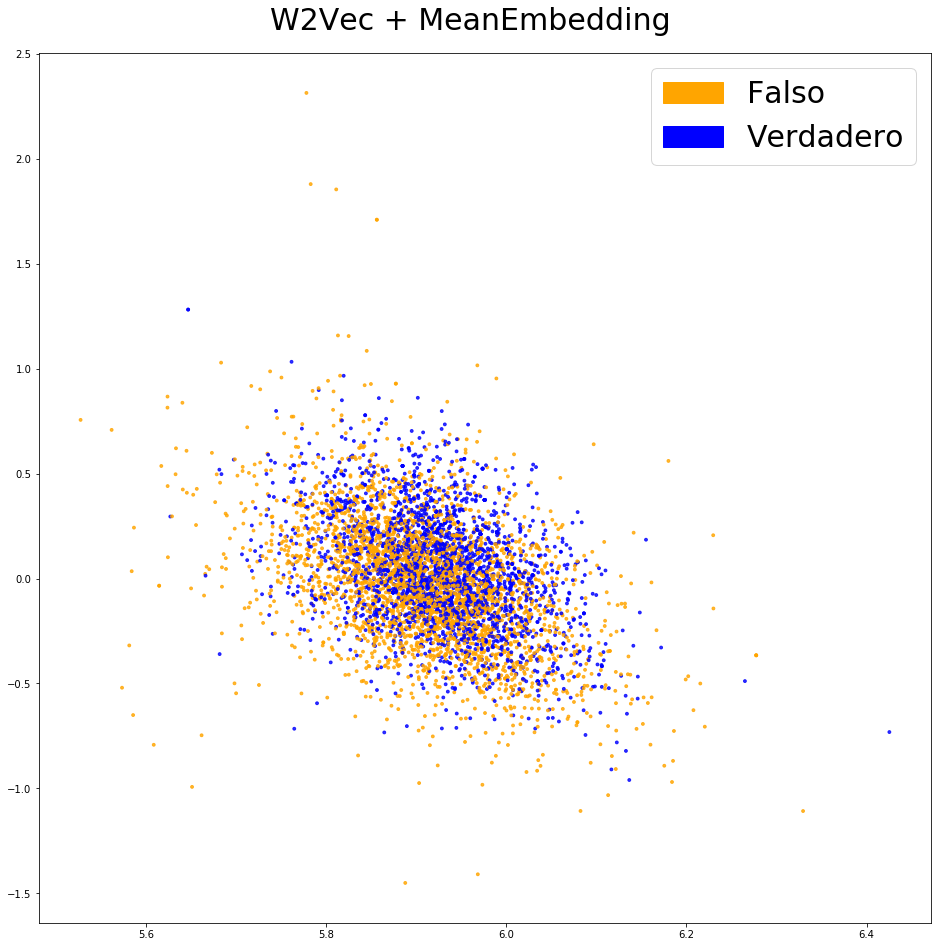

In [72]:
graph_w2vec_x = meanEmbedding.transform(X_train)
Graph_vectorization(graph_w2vec_x,y_train,"W2Vec + MeanEmbedding")

#### 2.1.2 Gráfico (TF-IDF) Embedding

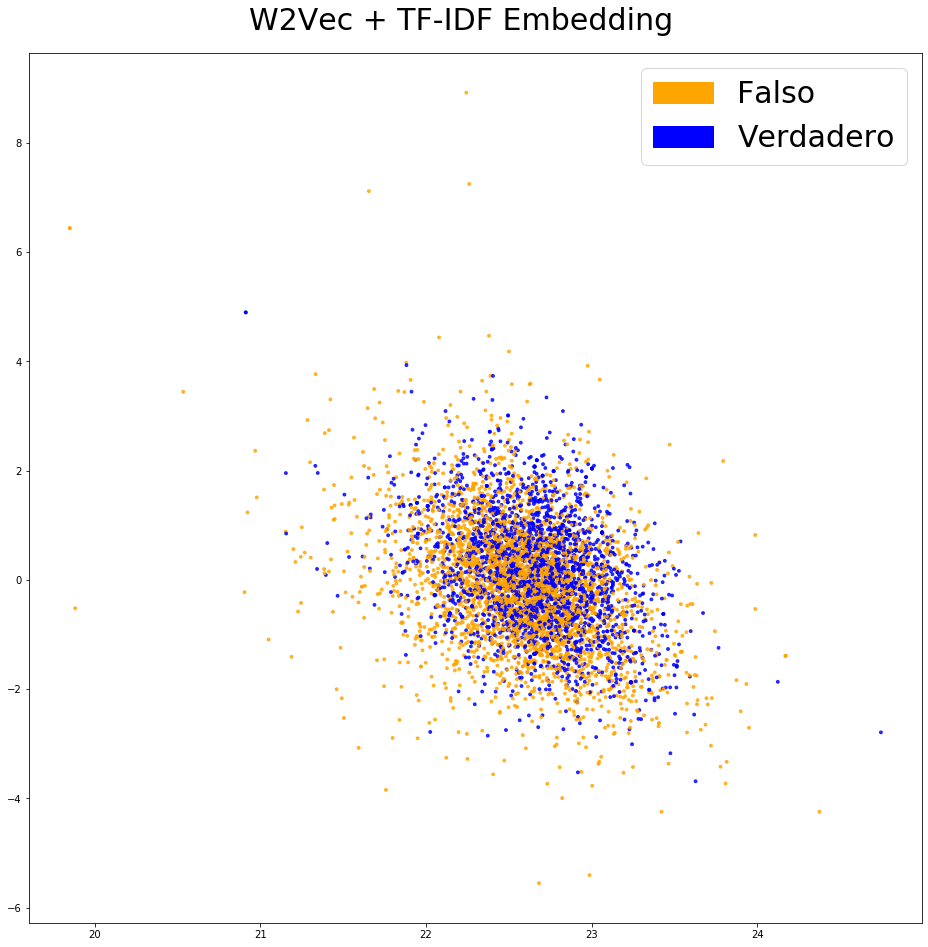

In [73]:
graph_w2vecTF_x = tfidfEmbedding.transform(X_train)
Graph_vectorization(graph_w2vecTF_x,y_train,"W2Vec + TF-IDF Embedding")

## 2.2 Universal Sentence Encoder (tensorflow)

USE (Universal sentence encoder) cifra el texto en vectores de alta dimensión que pueden ser utilizados en clasificación, similaridad semántica y clustering. El modelo es óptimo para textos grandes, como por ejemplo: oraciones, frases o parágrafos cortos.

In [53]:
large_use = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed = hub.load(large_use)
    
def transfrom(text_train, text_test):    
    vector_train = [tf.reshape(embed([line]), [-1]).numpy() for line in tqdm(text_train)]
    vector_test = [tf.reshape(embed([line]), [-1]).numpy() for line in tqdm(text_test)]

    return vector_train, vector_test
    

paso el texto a vectores, Lo hago con la columna **texto** y la columna **keyword**

In [58]:
train_use_tf, test_use_tf = transfrom(train_df2.text, test_df2.text)
train_use_tf_k, test_use_tf_k = transfrom(train_df2.keyword, test_df2.keyword)

#### 2.2.1 Gráfico Universal-Sentence-Encoder

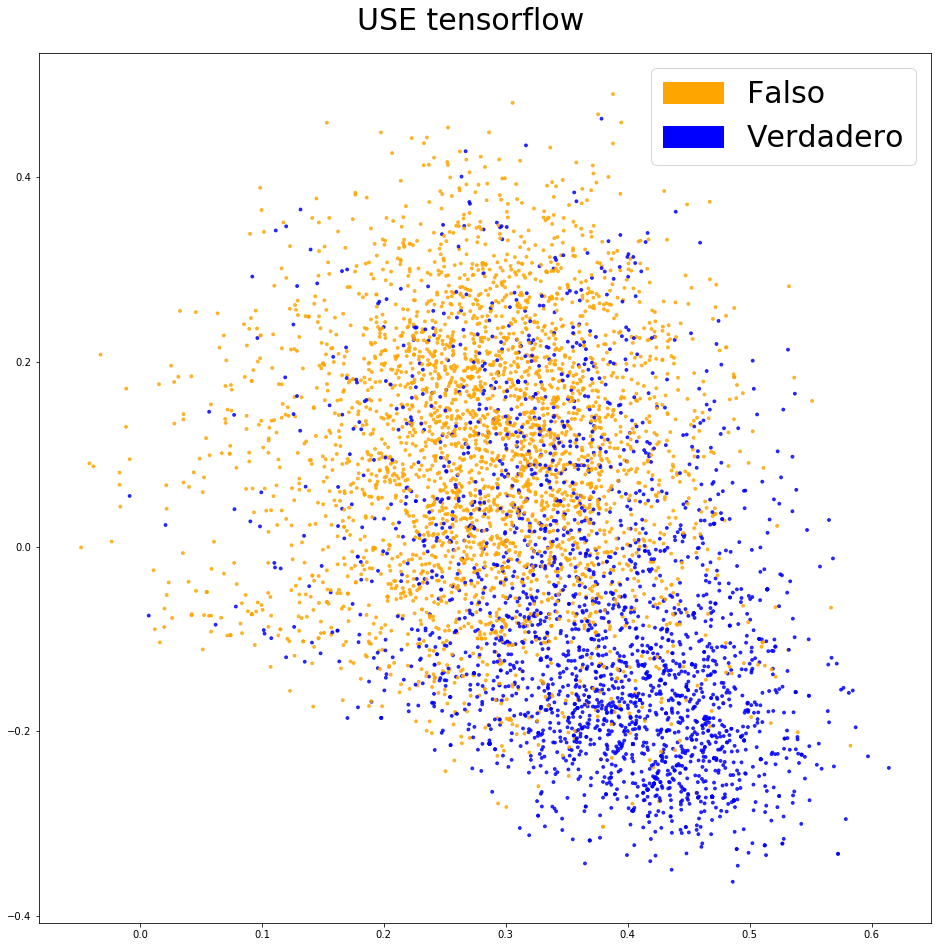

In [60]:
#Grafico vectorizacion
graph_useftx, _dummy = transfrom(X_train, X_train)
Graph_vectorization(graph_useftx,y_train,"USE tensorflow")

## 2.3 Bag of Words
Se crea un diccionario de palabras conocidas, luego de eso se representa el texto en un vector donde cada posición indica la existencia (o no) de las palabras.

### 2.3.1 CountVectorize

CountVectorize convierte una coleccion de documentos a una matriz de tokens contabilizados. Esta funcion incluye varios metodos para preprocedo/tokenizacion/stopwords, por lo que se podría modificar desde la siguiente línea. Sin embargo, como ya se hizo el pre-procesado del texto solo voy a usar la función sin ningun feature.

In [61]:
# Vectorizacion con countVectorize
count_vectorizer = CountVectorizer()
train_cv = count_vectorizer.fit_transform(train_df2['text'])
test_cv = count_vectorizer.transform(test_df2["text"])

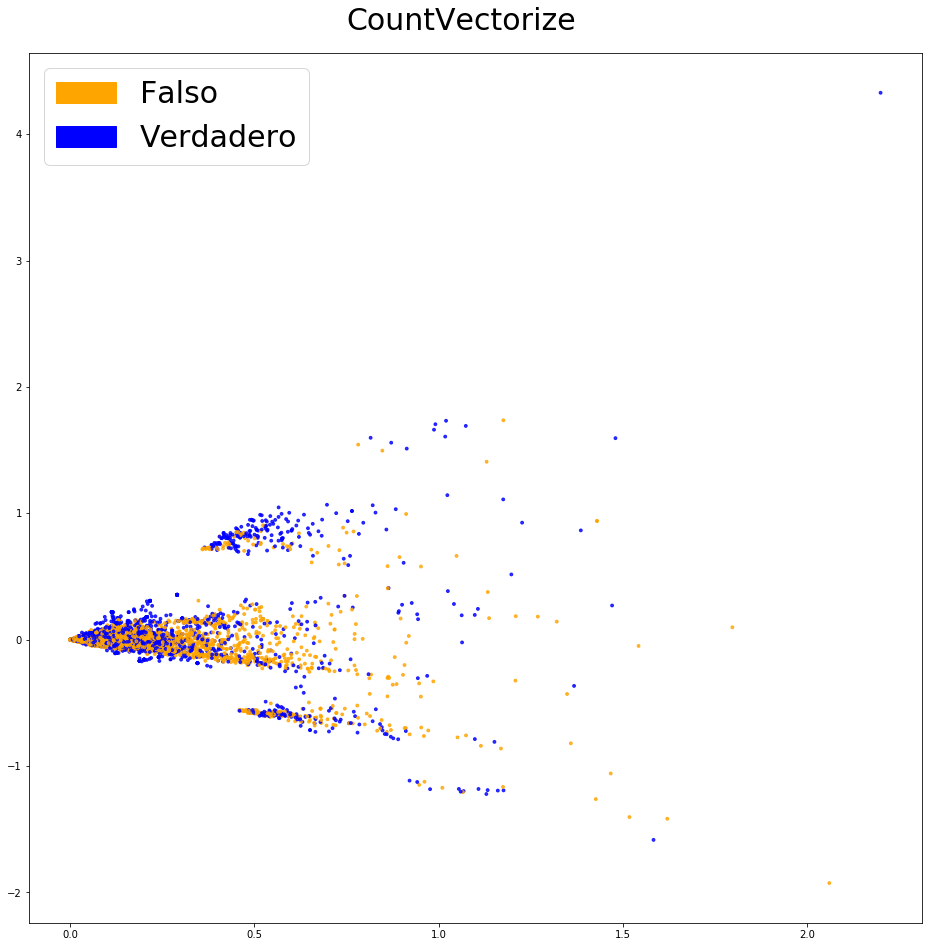

In [62]:
#Grafico vectorizacion
graph_cv =  count_vectorizer.fit_transform(X_train)
Graph_vectorization(graph_cv,y_train,"CountVectorize")

### 2.3.2 TF-IDF
Tf-idf (Term frequency – Inverse document frequency), frecuencia de término – frecuencia inversa de documento (o sea, la frecuencia de ocurrencia del término en la colección de documentos), es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección. 
Es una mejora de Bag of Words ya que contabiliza y pondera las palabras en base a su frecuencia de aparición en el documento, por ejemplo la palabra "the" puede tener muchas apariciones en el texto, por lo que se podria dar una importancia menor.

**Parámetros TfidfVectorizer**

* _mindf_ = cantidad o porcentaje minimo de aparición del token en todos los documentos. En este caso se descartan todas las que tengan menos de 2 apariciones

* _maxdf_ = cantidad o porcentaje maximo de aparición del token. En este caso se descartan todos los token que tengan una frecuencia de aparición mayor al 50%

* _ngramrange_ = Rango de ngramas a utilizar para generar los tokens. En este caso se usan desde 1 a 2 gramas (uni y bi-grama)


In [74]:
# Vectorizacion utilizando TF-IDF (UNI Y BI-GRAMAS)
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tf = tfidf.fit_transform(train_df2['text'])
test_tf = tfidf.transform(test_df2["text"])

* _Se toman los valores (min_df, max_df) porque acortan la dimensionalidad de los vectores_
* _Se utilizan uni y bi gramas porque mejora notablemente el scorde de clasificacion al agregar bi-gramas_


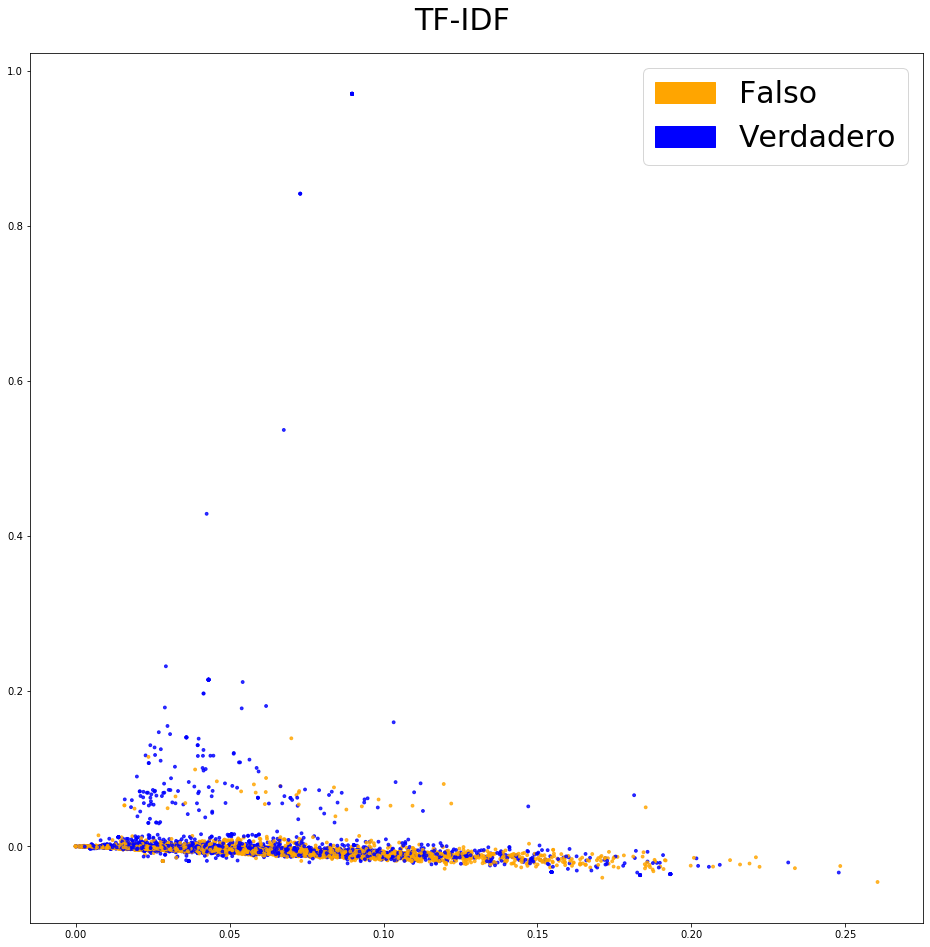

In [75]:
#Grafico vectorizacion
graph_tf =  tfidf.fit_transform(X_train)
Graph_vectorization(graph_tf,y_train,"TF-IDF")

### 2.3.4 N-Gramas
Agrupo las palabras en grupos de 1,2,3,n palabras, para agregarles un contexto.

Esto se puede lograr utilizando countVectorize para analizar la frecuencia de aparición de n-gramas o combinarlo con tf-idf para considerar la ponderación del término en base a sus apariciones.

In [65]:
# Agrupo por bi-gramas y tri-gramas con CountVectorizer
ngram_cv = CountVectorizer(ngram_range=(2,3))
train_ng_cv = ngram_cv.fit_transform(train_df2['text'])
test_ng_cv = ngram_cv.transform(test_df2["text"])

In [66]:
# Agrupo por bi-gramas y tri-gramas con TF-IDF
ngram_tf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(2, 3))
train_ng_tf = ngram_tf.fit_transform(train_df2['text'])
test_ng_tf = ngram_tf.transform(test_df2["text"])

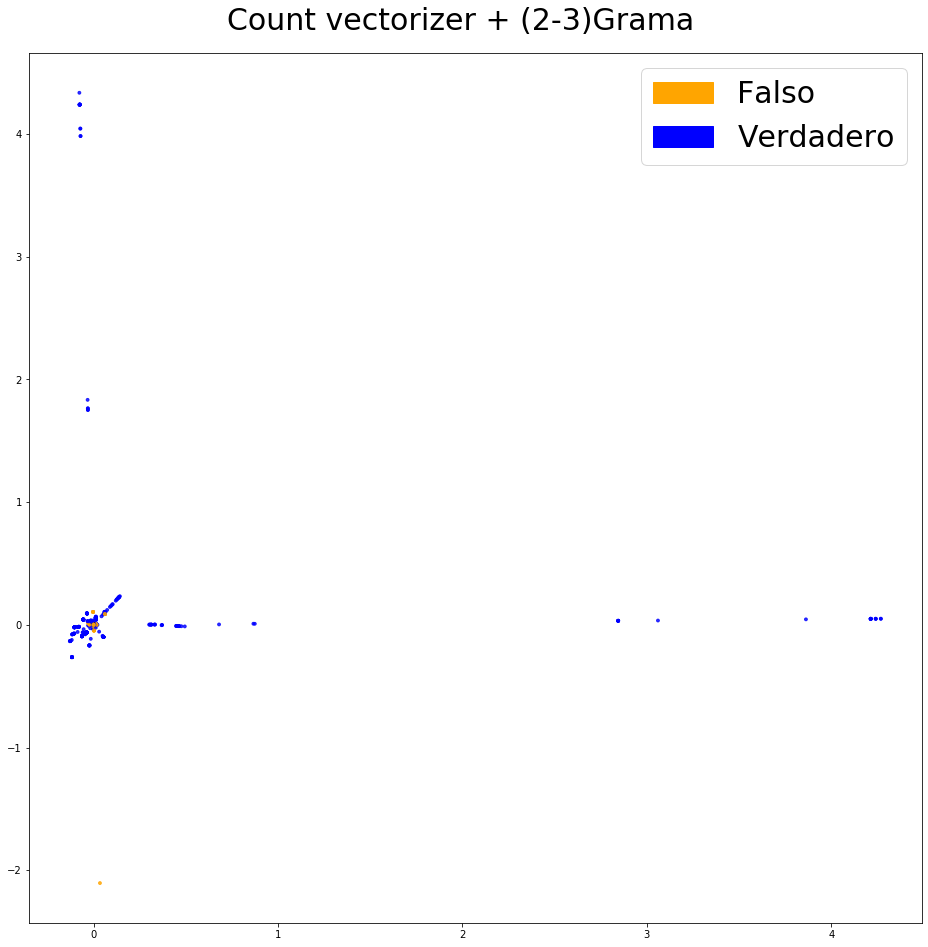

In [67]:
#Grafico vectorizacion
graph_cv_ngs =  ngram_cv.fit_transform(X_train)
Graph_vectorization(graph_cv_ngs,y_train,"Count vectorizer + (2-3)Grama")


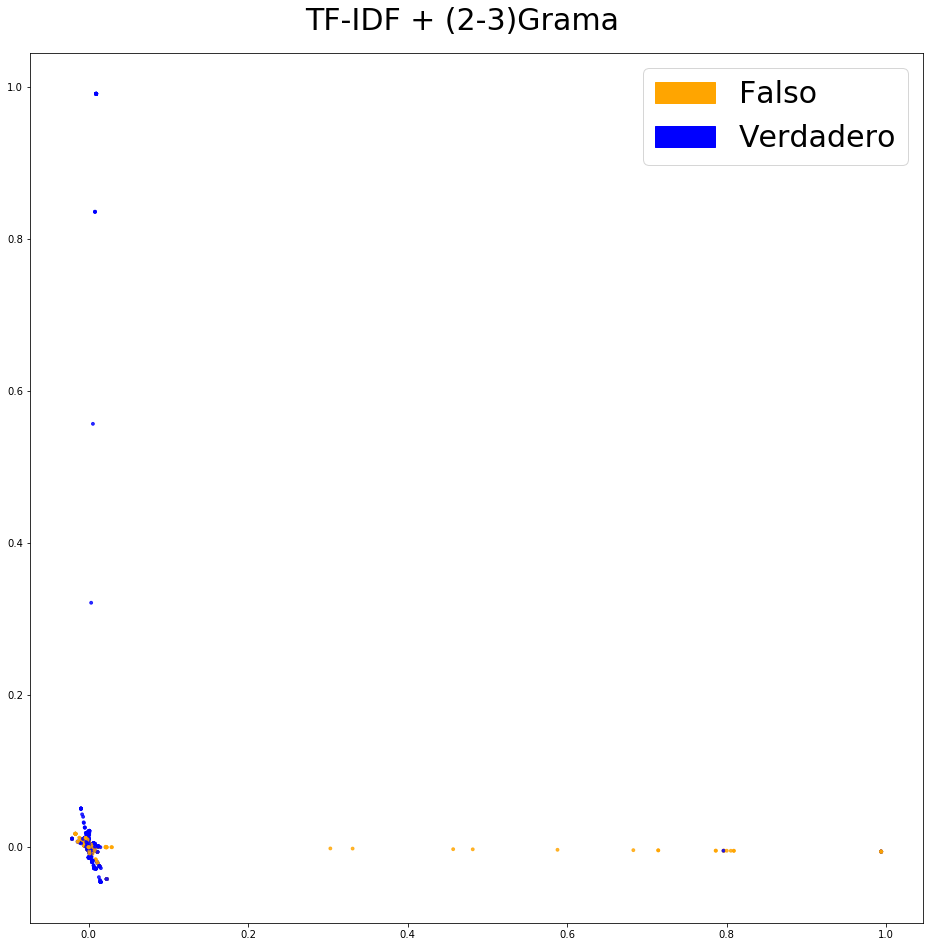

In [76]:
#Grafico vectorizacion
graph_tf_ng =  ngram_tf.fit_transform(X_train)
Graph_vectorization(graph_tf_ng,y_train,"TF-IDF + (2-3)Grama")

### 2.3.5 Feature Hashing


In [69]:
#Vectorizacion usando Feature hashing
hv = HashingVectorizer()
train_fh = hv.fit_transform(train_df2["text"])
test_fh = hv.transform(test_df2["text"])

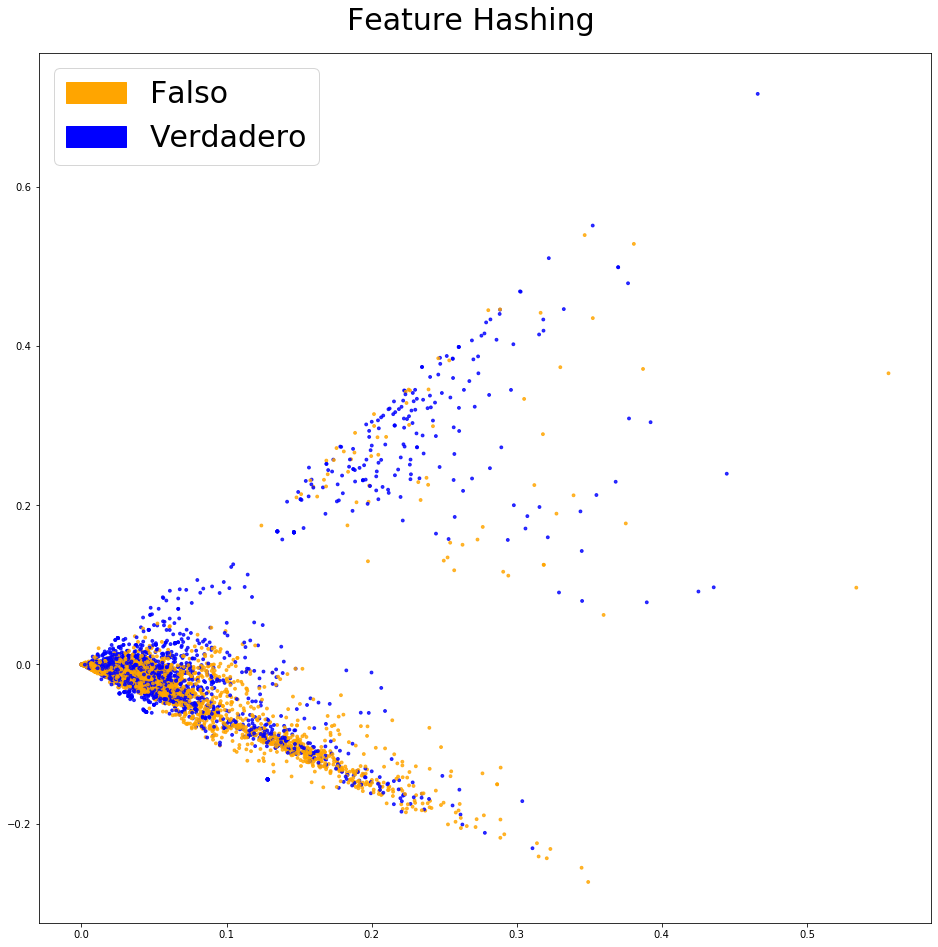

In [71]:
#Grafico vectorizacion
graph_fh =  hv.fit_transform(X_train)
Graph_vectorization(graph_fh,y_train,"Feature Hashing")

# 3. Entrenamiento del modelo 
Para el entrenamiento pruebo algunos algoritmos _(en verde los probados, en rojo los descartados por ineficientes)_
* <font color='green'>Logistic Regression </font>
* <font color='green'>Decision tree</font>
* <font color='green'>KNN</font>
* <font color='green'>Gradient Boosting Clasifier</font>
* <font color='green'>Random Forest</font>
* <font color='green'>RidgeClassifier</font>
* <font color='green'>MNB (MultinomialNB)</font>
* <font color='green'>Perceptron</font>
* <font color='green'>xgBoost</font>

### 3.1 Organizo algoritmos
Para tener un poco mas ordenado todo, agrupo los algortimos en una colección para luego poder evaluarlos en bloque.

In [ ]:
#Creo diccionario con los modelos de regresion a probar.
modelsDict = {    
    "Gradient Boost": GradientBoostingClassifier(n_estimators=10),
    "Random Forest": RandomForestClassifier(max_depth = 10),  
    "Decision Tree": DecisionTreeClassifier(max_depth = 10),
    "kNN": KNeighborsClassifier(n_neighbors=20),
    'MNB': MultinomialNB(),
    'GNB': GaussianNB(),
    'RidgeClassifier': RidgeClassifier(class_weight='balanced'),
    'Perceptron': Perceptron(class_weight='balanced'),
    'xgboost': XGBClassifier(n_estimators=10),
    "Logistic Regression": LogisticRegression(C=1.0)
    }

no_classifiers = len(modelsDict.keys())


In [ ]:

def batch_classify(x_train, y_train, x_test, y_test,positive_values = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,6)), columns = ['Clasificador', 'Prec. train', 'Prec. test','AUC score','F1', 'Tiempo transcurrido'])
    count = 0
    for key, classifier in modelsDict.items():
        if positive_values == False and key == "MNB":
            continue
            
        t_start = process_time()  
        try:
            classifier.fit(x_train, y_train)
            t_stop = process_time() 
            t_elapsed = t_stop - t_start        
            y_predicted = classifier.predict(x_test)
            df_results.loc[count,'AUC score'] = roc_auc_score(y_test, y_predicted)
            df_results.loc[count,'Prec. train'] = round(classifier.score(x_train, y_train)*100)
            df_results.loc[count,'Prec. test'] =round(accuracy_score(y_test,y_predicted)*100) 
            df_results.loc[count,'F1'] = f1_score(y_test, y_predicted, zero_division=1)
        except Exception as e:
            #agrego esto para los casos de vectores negativos para seguir adelante y no analizar ese modelo
            print(e)
        
        df_results.loc[count,'Clasificador'] = key        
        df_results.loc[count,'Tiempo transcurrido'] = t_elapsed                  
        count+=1

    return df_results


In [ ]:
#Datos para countVector
x_train_cv, x_test_cv, y_train_cv, y_test_cv =train_test_split(train_cv,tweets_train.target,test_size=0.2,random_state=2020)
cv_results = batch_classify(x_train_cv, y_train_cv,x_test_cv, y_test_cv)


In [ ]:
#Datos para TF-IDF
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(train_tf,tweets_train.target,test_size=0.2,random_state=2020)
tf_results = batch_classify(x_train_tf, y_train_tf,x_test_tf, y_test_tf)


In [ ]:
#Datos para countVector + n-gramas
x_train_ng_cv, x_test_ng_cv, y_train_ng_cv, y_test_ng_cv =train_test_split(train_ng_cv,tweets_train.target,test_size=0.2,random_state=2020)
cv_ng_results = batch_classify(x_train_ng_cv, y_train_ng_cv,x_test_ng_cv, y_test_ng_cv)


In [ ]:
#Datos para TF-IDF + n-gramas
x_train_ng_tf, x_test_ng_tf, y_train_ng_tf, y_test_ng_tf = train_test_split(train_ng_tf,tweets_train.target,test_size=0.2,random_state=2020)
tf_ng_results = batch_classify(x_train_ng_tf, y_train_ng_tf,x_test_ng_tf, y_test_ng_tf)


In [ ]:
#Datos para Feature hashing
x_train_fh, x_test_fh, y_train_fh, y_test_fh = train_test_split(train_fh,tweets_train.target,test_size=0.2,random_state=2020)
fh_results = batch_classify(x_train_fh,y_train_fh,x_test_fh,y_test_fh,False)

In [ ]:
#Datos para w2vec
x_train_w2vec, x_test_w2vec, y_train_w2vec, y_test_w2vec = train_test_split(train_w2vec,tweets_train.target,test_size=0.2,random_state=2020)
w2vec_results = batch_classify(x_train_w2vec, y_train_w2vec,x_test_w2vec, y_test_w2vec)

In [ ]:
#Datos para w2vec+tfid
x_train_w2vecTfid, x_test_w2vecTfid, y_train_w2vecTfid, y_test_w2vecTfid = train_test_split(train_w2vecTfid,tweets_train.target,test_size=0.2,random_state=2020)
w2vecTfid_results = batch_classify(x_train_w2vecTfid, y_train_w2vecTfid,x_test_w2vecTfid, y_test_w2vecTfid)

In [ ]:
#Datos para U.S.E TF
x_train_usetf, x_test_usetf, y_train_usetf, y_test_usetf = train_test_split(train_use_tf,tweets_train.target,test_size=0.2,random_state=2020)
usetf_results = batch_classify(x_train_usetf, y_train_usetf,x_test_usetf, y_test_usetf)

# 4. Resultados
Comparo la performance de los distintos modelos probados

In [ ]:
# Imprimo resultados para countVector
cv_results.sort_values(by=["Prec. test", "AUC score"], ascending=(False,False))

In [ ]:
# Imprimo resultados para TF-IDF
tf_results.sort_values(by=["Prec. test", "AUC score"], ascending=(False,False))

In [ ]:
# Imprimo resultados para countVector + n-gramas
cv_ng_results.sort_values(by=["Prec. test", "AUC score"], ascending=(False,False))

In [ ]:
# Imprimo resultados para TF-IDF + n-gramas
tf_ng_results.sort_values(by=["Prec. test", "AUC score"], ascending=(False,False))

In [ ]:
#Imprimo datos para Feature Hashing
fh_results.sort_values(by=["Prec. test","AUC score"],ascending=(False,False))

In [ ]:
# w2vec
w2vec_results.sort_values(by=["Prec. test", "AUC score"], ascending=(False,False))

In [ ]:
# w2vec + tfid
w2vecTfid_results.sort_values(by=["Prec. test", "AUC score"], ascending=(False,False))

In [ ]:
#Tensorflow universal setence encoder
usetf_results.sort_values(by=["Prec. test","AUC score"],ascending=(False,False))

### 4.1 Analísis general
comparo las metricas de todos los modelos.

In [ ]:
def graph_classifier(x_train, y_train,title):
    results = []
    names = []
    for key, classifier in modelsDict.items():
        kfold = model_selection.KFold(n_splits=10, random_state=2020)
        cv_results = model_selection.cross_val_score(classifier, x_train, y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(key)    
        
    fig = plt.figure(figsize=(16,8))
    plt.title(title)
    fig.suptitle('Comparación de algoritmos')    
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)    
    plt.axhline(y=0.80, color='g', linestyle='-')
    plt.show()


In [ ]:
#Datos para countVector
graph_classifier(x_train_cv, y_train_cv,"CountVector")

In [ ]:
#Datos para TF-IDF
graph_classifier(x_train_tf, y_train_tf,"TF-IDF (1-2-grama)")

In [ ]:
#Datos para countVector + n-gramas
graph_classifier(x_train_ng_cv, y_train_ng_cv,"CountVector (1-3-grama)")

In [ ]:
#Datos para TF-IDF ngramas
graph_classifier(x_train_ng_tf, y_train_ng_tf,"TF-IDF (1-3-grama)")

In [ ]:
#Datos para Feature Hashing
graph_classifier(x_train_fh, y_train_fh,"Feature Hashing")

In [ ]:
#Datos para w2vec
graph_classifier(x_train_w2vec, y_train_w2vec,"w2vec")

In [ ]:
#Datos para w2vec+tfid
graph_classifier(x_train_w2vecTfid, y_train_w2vecTfid,"w2vec")

In [ ]:
#Datos para Tensorflor universal setence encode
graph_classifier(x_train_usetf, y_train_usetf,"Tensorflow USE")

# 5. Mejora y selección de modelos
Para encontrar las mejores configuraciones de los modelos, testeo distintos hiperparámetros dentro de cada modelo. Hago una selección entre los mejores candidatos.

### 5.0 Pre-seleccion de los mejores modelos
Para no comparar todos los modelos y sus combinaciones, elijo los que mejor resultado dieron

In [ ]:
#del modelsDict["Key"] 


### 5.1 Búsqueda de hiperparámetros
Veo los hiperparámetros que tiene cada modelo

In [ ]:
for key, classifier in modelsDict.items():
    print("Key: " + key)
    print(classifier.get_params().keys())
    print("-"*50)


Creo un diccionario para almacenar la colección de hiperparámetros

In [ ]:
modelsHyper = dict()
modelsDict.keys()

##### 5.1.1 Gradient Boost

In [ ]:
modelsHyper["Gradient Boost"] = {
    "":"",
    "":""
}

##### 5.1.2 Random Forest

In [ ]:
modelsHyper["Random Forest"] = {
    "":"",
    "":""
}

##### 5.1.3 Decision Tree

In [ ]:
modelsHyper["Decision tree"] = {
    "":"",
    "":""
}

##### 5.1.4 KNN

In [ ]:
modelsHyper["kNN"] = {
    "":"",
    "":""
}

##### 5.1.5 MNB

In [ ]:
modelsHyper["MNB"] = {
    "":"",
    "":""
}

##### 5.1.6 GNB

In [ ]:
modelsHyper["GNB"] = {
    "":"",
    "":""
}

##### 5.1.7 RidgeClassifier

In [ ]:
modelsHyper["Ridge Classifier"] = {
    "":"",
    "":""
}

##### 5.1.8 Perceptron

In [ ]:
modelsHyper["Perceptron"] = {
    "":"",
    "":""
}

##### 5.1.9 xgBoost

In [ ]:
modelsHyper["xgboost"] = {
    "":"",
    "":""
}

##### 5.1.10 Logistic Regression

In [ ]:
modelsHyper["Logistic Regression"] = {
    "":"",
    "":""
}

### 5.2 Seleccion de Hiperparametros
Utilizo gridsearch para buscar los mejores hiperparametros para cada modelo.


In [ ]:
def Cross_validation(classifier,param_grid):
    grid_search = GridSearchCV(estimator= classifier, param_grid = param_grid, cv=3 , n_jobs = -1, verbose = 2)
    grid_search.fit(x_train_usetf,y_train_usetf)
    return grid_search.best_estimator_

# 6. Envío de datos
Preparo el submit

In [ ]:
def submission(model,test_vector):
    
    '''Input- model=final fit model to be used for predictions
              test_vector=pre-processed and vectorized test dataset
       Output- submission file in .csv format with predictions       
    
    '''    
    sub_df = pd.read_csv('../data/sample_submission.csv')
    sub_df["target"] = model.predict(test_vector)
    sub_df.to_csv("submission.csv", index=False)
        

In [ ]:
#MNB + countVector
mnb_model = MultinomialNB()
mnb_model.fit(x_train_cv, y_train_cv)
submission(mnb_model,test_cv)

In [ ]:
#Logistic Regression +TF-IDF (1-2-gramas)
lr_model = LogisticRegression(C=1.0)
lr_model.fit(x_train_tf, y_train_tf)
submission(lr_model,test_tf)

In [ ]:
#MNB + TF-IDF (1-2-gramas)
mnb_model = MultinomialNB()
mnb_model.fit(x_train_tf, y_train_tf)
submission(mnb_model,test_tf)

In [ ]:
# TensorFlow + RandomForest (0.80324)
trf_model = modelsDict["Random Forest"]
trf_model.fit(x_train_usetf,y_train_usetf)
submission(trf_model,test_use_tf)

In [ ]:
# TensorFlow + Knn (0.78884)
tknn_model = modelsDict["kNN"]
tknn_model.fit(x_train_usetf,y_train_usetf)
submission(tknn_model,test_use_tf)

In [ ]:
# TensorFlow + Ridge (0.79221)
trid_model = modelsDict["RidgeClassifier"]
trid_model.fit(x_train_usetf,y_train_usetf)
submission(trid_model,test_use_tf)

In [ ]:
# TensorFlow + Logistic Reg (0.80416)
tlr_model = modelsDict["Logistic Regression"]
tlr_model.fit(x_train_usetf,y_train_usetf)
submission(tlr_model,test_use_tf)

In [ ]:
# Randomforest + Hiperparams
hip_model = modelsDict["RandomForest up"]
hip_model.fit(x_train_usetf,y_train_usetf)
submission(hip_model,test_use_tf)

In [ ]:
# Tensorflor --- logistic + Hyper (0.80876)
lrh_model = LogisticRegression(C=0.615848211066026, solver='liblinear')
lrh_model.fit(x_train_usetf,y_train_usetf)
submission(lrh_model,test_use_tf)